In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import obspy
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset
import pickle as pkl

import copy


import pandas as pd
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

import pyTMD
import numpy as np
        
import pyTMD.io
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities
import timescale.time

np.float_ = np.float64
import dascore as dc

def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']


    fs = attrs['PulseRate'] #sample rate
    bp_top = 200
    bp_bottom = 1
    downsample_rate = int(fs/bp_top)

    #filter by freq
    sos = signal.butter(10, [bp_bottom,bp_top], 'bp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)

    #FK filter
    new_format_times = time_fixer_4_fk(times)
    dims = ('time', 'distance')
    patch = dc.Patch(data=filtered, coords=dict(time=[np.datetime64(i) for i in new_format_times], distance=x), dims=dims)
    filt_cutoffs = np.array([0, 400, 8000, np.inf])

    fk_filtered = patch.slope_filter(filt=filt_cutoffs)
    fk_filtered_data = np.array(fk_filtered.data)


    #normalize
    data_normed_filtered = chan_norm(fk_filtered_data)

    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)
    # print(filled_data.shape)
    # print(first_filler.shape)
    filled_data = np.zeros((int(fs*60),data_normed_filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)




    if data_locator[0]==0:
        filled_data[data_locator] = data_normed_filtered

    else:
        first_filler = np.array([data_normed_filtered[:,0]]*data_locator[0])
        filled_data[:first_filler.shape[0],:] = first_filler
    
    filt_filled_data = filled_data

    filled_times[data_locator] = times
    # filled_data[data_locator] = data_normed_filtered.T

    # filt_filled_data = filled_data

    ## Downsample 
    filled_times = filled_times[::downsample_rate]
    filt_filled_data = filt_filled_data[::downsample_rate,::5] #Skip every 5th channel
    new_dict = dict(attrs)
    new_dict['PulseRate'] = new_dict['PulseRate']/downsample_rate


    return filt_filled_data, filled_times, new_dict

def foo(a):
    t = mdates.num2date(a)
    ms = str(t.microsecond)[:1]
    res = f"{t.hour:02}:{t.minute:02}:{t.second:02}.{ms}"
    return res

def chan_norm(das_data):
    data_normed = (das_data - np.mean(das_data, axis=0))/np.std(das_data, axis=0).T
    # data_normed_all_axis = (data_normed.T - np.mean(data_normed, axis=1))/np.std(data_normed, axis=1)   

    return data_normed

class DataStats:
    def __init__(self, data, attrs, times):
        self.sampling_rate = attrs["PulseRate"]
        self.npts = data.shape[0]
        self.starttime = times[0]
        # self.starttime.isoformat

class DAS:
    def __init__(self, id, data, attrs, times):
        self.id = id
        self.data = data
        self.stats = DataStats(data, attrs, times)


def obspy_stream_from_das(data, attrs,times):
    stats_default = {
        'network':'eastwind',
        'station':'',
        'location':'',
        'channel':'DAS',
        'starttime':times[0].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'endtime':times[-1].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'sampling_rate':attrs['PulseRate'],
        'delta':1/attrs['PulseRate'],
        'npts':0,
        'calib':1.0
    }

    streams = []
    for n,i in enumerate(data.T):
        tr = obspy.Trace(data=i,header=stats_default)
        # tr.stats.station = f'Channel {n}'
        tr.stats.npts = len(i)

        st = obspy.Stream(tr)
        streams.append(st)
    return streams

def parallel_event_finding(dummy):
    times_all,attrs,channel,all_data = dummy
    trigger_on=3.5, 
    trigger_off=1.2
    
    DAS_channel = DAS(channel, all_data, attrs, times_all)


    cft = recursive_sta_lta(DAS_channel.data, int(1 * attrs['PulseRate']), int(10 * attrs['PulseRate']))
    trigger_times = trigger_onset(cft, trigger_on, trigger_off)
    trigger_times_list = [trigger_times]     

    trigger_times_list_datetime = []

    for trigs_samp_time in trigger_times_list:
        trigger_times_list_datetime.append(times_all[trigs_samp_time])
    return {str(channel): trigger_times_list_datetime}


def time_fixer_4_fk(times):
    times_copy = times.copy()
    new_format_times = []
    for i in times_copy:
        if round(i.microsecond/500)*500 == 1000000:
            microsecond = 0
            second = i.second + 1
            minute = i.minute
            hour = i.hour
            day = i.day
            if second == 60:
                second = 0
                minute = minute+1

            if minute == 60:
                minute = 0
                hour=hour+1
            
            if hour == 24:
                hour = 0
                day = day+1
            
        else:
            microsecond = int(round(i.microsecond/500)*500)
            second = i.second
            minute = i.minute
            hour = i.hour
            day = i.day

        new_format_times.append(datetime.datetime(year=i.year,
                                                month=i.month,
                                                day=day,
                                                hour=hour,
                                                minute=minute,
                                                second=second,
                                                microsecond=microsecond))
    return new_format_times


import pathlib



import pandas as pd
from obspy import UTCDateTime
from obspy.clients.fdsn.mass_downloader import (
    GlobalDomain,
    Restrictions,
    MassDownloader,
)
from obspy.core import AttribDict
from pyproj import Proj
from multiprocessing import Pool

from quakemigrate import QuakeScan, Trigger
from quakemigrate.io import Archive, read_stations
from quakemigrate.lut import compute_traveltimes
from quakemigrate.signal.onsets import STALTAOnset
from quakemigrate.signal.pickers import GaussianPicker
%matplotlib widget

In [2]:
with open('auto_picked_events_all_5thChannel.pkl', 'rb') as file:
    picks = pkl.load(file)

picks = picks[:int(len(picks))] # We skipped every 5th channel

In [3]:

all_trigs_flat_no_duplicates = []

for i in picks:
    all_trigs_flat_no_duplicates.append([i[0]])
for chan in range(len(picks)):
    chan_picks = picks[chan]
    for k in range(1,len(chan_picks), 1):

        try:
            diff = chan_picks[k] - chan_picks[k-1]
            if diff < datetime.timedelta(seconds=0.01):
                # print('duplicate')
                continue

            else:
                all_trigs_flat_no_duplicates[chan].append(chan_picks[k])
        except:
            continue

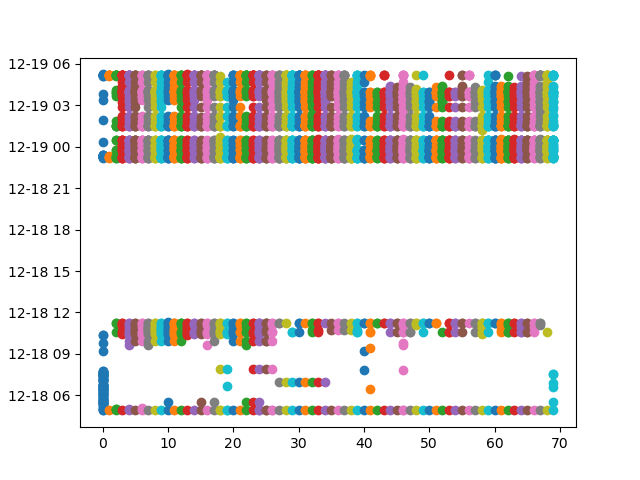

In [4]:
fig,ax = plt.subplots()

for chan,p in enumerate(all_trigs_flat_no_duplicates):
    ax.scatter([chan]*len(p),p)

In [5]:
# available model list
model_list = sorted(pyTMD.io.model.ocean_elevation())
# display widgets for setting directory and model
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'GOT4.10_nc'
TMDwidgets.VBox([
    TMDwidgets.directory,
    TMDwidgets.model,
    TMDwidgets.datepick
])

In [6]:
# default coordinates to use
LAT,LON = (-77.777664,167.868027)
m = pyTMD.tools.leaflet(center=(LAT,LON), zoom=7,
    zoom_control=True, marker_control=True,
    attribution=False)
# show map
m.map

Map(center=[-77.777664, 167.868027], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [7]:
# get model parameters
model = pyTMD.io.model(TMDwidgets.directory.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = TMDwidgets.datepick.value
# calculate a weeks forecast every minute
minutes = np.arange(7*1440)
# convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
ts = timescale.from_calendar(YMD.year, YMD.month,
    YMD.day, minute=minutes)
hours = minutes/60.0

# create plot with tidal displacements, high and low tides and dates
fig,ax1 = plt.subplots(num=1)
xmax = np.ceil(hours[-1]).astype('i')
l1, = ax1.plot([], [], 'k')
l2, = ax1.plot([], [], 'r*')
l3, = ax1.plot([], [], 'b*')
for h in range(24,xmax,24):
    ax1.axvline(h,color='gray',lw=0.5,ls='dashed',dashes=(11,5))
ax1.set_xlim(0,xmax)
ax1.set_ylabel(f'{model.name} Tidal Displacement [cm]')
args = (YMD.year,YMD.month,YMD.day)
ax1.set_xlabel('Time from {0:4d}-{1:02d}-{2:02d} UTC [Hours]'.format(*args))
ttl = ax1.set_title(None)
fig.subplots_adjust(left=0.11,right=0.98,bottom=0.10,top=0.95)

# read tidal constants and interpolate to leaflet points
if model.format in ('OTIS','ATLAS-compact','TMD3'):
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file, model.model_file,
        model.projection, type=model.type,
        grid=model.file_format)
    c = constituents.fields
    DELTAT = np.zeros_like(ts.tide)
elif (model.format == 'ATLAS-netcdf'):
    constituents = pyTMD.io.ATLAS.read_constants(
        model.grid_file, model.model_file,
        type=model.type, compressed=model.compressed)
    c = constituents.fields
    DELTAT = np.zeros_like(ts.tide)
elif model.format in ('GOT-ascii', 'GOT-netcdf'):
    constituents = pyTMD.io.GOT.read_constants(
        model.model_file, grid=model.file_format,
        compressed=model.compressed)
    c = constituents.fields
    # delta time (TT - UT1)
    DELTAT = ts.tt_ut1
elif (model.format == 'FES-netcdf'):
    constituents = pyTMD.io.FES.read_constants(model.model_file,
        type=model.type, version=model.version,
        compressed=model.compressed)
    c = model.constituents
    # delta time (TT - UT1)
    DELTAT = ts.tt_ut1

# update the tide prediction and plot
def update_tide_prediction(*args):
    # leaflet location
    LAT,LON = np.copy(m.marker.location)
    # verify longitudes
    LON = m.wrap_longitudes(LON)
    if model.format in ('OTIS','ATLAS-compact','TMD3'):
        amp,ph,D = pyTMD.io.OTIS.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, projection=model.projection, type=model.type,
            method='spline', extrapolate=True)
    elif (model.format == 'ATLAS-netcdf'):
        amp,ph,D = pyTMD.io.ATLAS.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, type=model.type, scale=model.scale,
            method='spline', extrapolate=True)
    elif model.format in ('GOT-ascii', 'GOT-netcdf'):
        amp,ph = pyTMD.io.GOT.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, scale=model.scale,
            method='spline', extrapolate=True)
    elif (model.format == 'FES-netcdf'):
        amp,ph = pyTMD.io.FES.interpolate_constants(
            np.atleast_1d(LON), np.atleast_1d(LAT),
            constituents, scale=model.scale,
            method='spline', extrapolate=True)
    # calculate complex phase in radians for Euler's
    cph = -1j*ph*np.pi/180.0
    # calculate constituent oscillation
    hc = amp*np.exp(cph)
    # predict tidal elevations at time and infer minor corrections
    TIDE = pyTMD.predict.time_series(ts.tide, hc, c,
        deltat=DELTAT, corrections=model.corrections)
    MINOR = pyTMD.predict.infer_minor(ts.tide, hc, c,
        deltat=DELTAT, corrections=model.corrections)
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    # differentiate to calculate high and low tides
    diff = np.zeros_like(ts.tide, dtype=np.float64)
    # forward differentiation for starting point
    diff[0] = TIDE.data[1] - TIDE.data[0]
    # backward differentiation for end point
    diff[-1] = TIDE.data[-1] - TIDE.data[-2]
    # centered differentiation for all others
    diff[1:-1] = (TIDE.data[2:] - TIDE.data[0:-2])/2.0
    # indices of high and low tides
    htindex, = np.nonzero((np.sign(diff[0:-1]) >= 0) & (np.sign(diff[1:]) < 0))
    ltindex, = np.nonzero((np.sign(diff[0:-1]) <= 0) & (np.sign(diff[1:]) > 0))
    # update plot data
    l1.set_data(hours, TIDE.data)
    l2.set_data(hours[htindex], TIDE.data[htindex])
    l3.set_data(hours[ltindex], TIDE.data[ltindex])
    # update plot title
    ttl.set_text(u'{0:0.6f}\u00b0N {1:0.6f}\u00b0E'.format(LAT,LON))
    ax1.relim()
    ax1.autoscale_view()
    fig.canvas.draw()

    return TIDE, hours

# run tide prediction at initial location
TIDE, hours = update_tide_prediction()
# watch marker location for changes
m.marker_text.observe(update_tide_prediction)

In [8]:
YMD_datetime = datetime.datetime(year=YMD.year, month=YMD.month, day=YMD.day)

dates_of_tides = []

for i in hours:
    dates_of_tides.append(YMD_datetime + timedelta(hours=i))

In [9]:
data_end0 = datetime.datetime(year=2024, 
                                month=12, 
                                day=17, 
                                hour=4, 
                                minute=54)

data_start1 = datetime.datetime(year=2024, 
                                month=12, 
                                day=18, 
                                hour=4, 
                                minute=54)

data_end1 = datetime.datetime(year=2024, 
                                month=12, 
                                day=18, 
                                hour=11, 
                                minute=19)

data_start2 = datetime.datetime(year=2024, 
                                month=12, 
                                day=18, 
                                hour=23, 
                                minute=7)

data_end2 = datetime.datetime(year=2024, 
                                month=12, 
                                day=19, 
                                hour=5, 
                                minute=16)

data_start3 = datetime.datetime(year=2024, 
                                month=12, 
                                day=20, 
                                hour=5, 
                                minute=16)

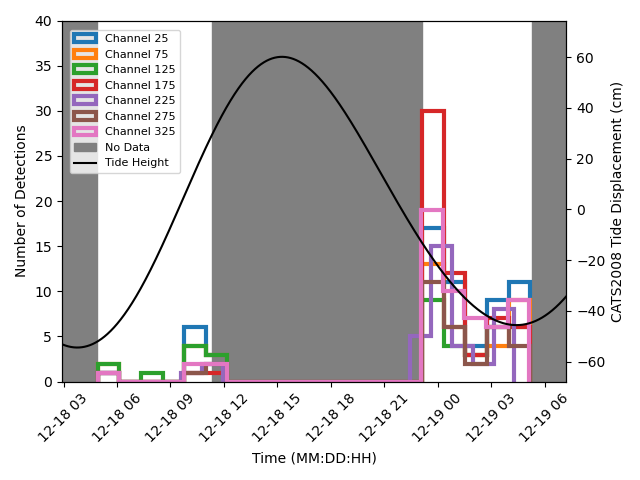

In [20]:
flat_list = [
    x
    for xs in all_trigs_flat_no_duplicates
    for x in xs
]


fig,ax= plt.subplots()
chans_of_interest = np.arange(5,len(all_trigs_flat_no_duplicates),10)

for i in chans_of_interest:

    ax.hist(all_trigs_flat_no_duplicates[i], bins = 20, histtype='step', 
            label='Channel '+str(i*5), 
            linewidth=3)


ax2 = ax.twinx()
ln2 = ax2.plot(dates_of_tides, TIDE.data, '-k', label='Tide Height')





ax.fill_betweenx([0,40],data_end0,data_start1, label='No Data', color='gray')
ax.fill_betweenx([0,40],data_end1,data_start2, color='gray')
ax.fill_betweenx([0,40],data_end2,data_start3, color='gray')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.45, 0.5, 0.5), fontsize=8)

ax.set_ylim([0,40])
ax.set_xlim([np.array(flat_list).min() - timedelta(hours=2), 
             np.array(flat_list).max() + timedelta(hours=2)])

plt.xticks(rotation=45)

labels = ax2.get_xticklabels()
ticks = ax2.get_xticks()
ax.set_xticks(ticks, labels, rotation=45)

ax.set_ylabel('Number of Detections')
ax2.set_ylabel('CATS2008 Tide Displacement (cm)')
ax.set_xlabel('Time (MM:DD:HH)')

plt.tight_layout()

# plt.savefig('Figures/fig3_eastwind.png', dpi=300, transparent=False)


In [11]:
num_events = []
for i in all_trigs_flat_no_duplicates:
    num_events.append(len(i))


In [12]:
np.average(num_events)

np.float64(50.34285714285714)